In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np
#import matplotlib as mpl
import cv2  # conda install -c conda-forge opencv
from moviepy.editor import VideoFileClip

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams['axes.grid'] = False
#plt.style.use('dark_background')
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15

background_color = "w"

In [1]:
vid_filename = "2024_0201_152845_091_10sec"
vid_extension = ".mov"
vid_filepath = f"./data/videos/individual-rotifer/{vid_filename}{vid_extension}"
seg_mask_path = f"./data/results/{vid_filename}_masks"  # inching w/o substrate, then sample then take-off, 315 frames

fps = VideoFileClip(vid_filepath).fps  # get from file original, not segmented
resolution = VideoFileClip(vid_filepath).size

NameError: name 'VideoFileClip' is not defined

# Frame extraction

In [36]:
frames_filepath = f"./data/images/{vid_filename}/"
os.makedirs(frames_filepath, exist_ok=True)
zfill_ = 5  # correspond to seg-masks

video = cv2.VideoCapture(vid_filepath)
frame_counter = 0
while True:
    ret, frame = video.read()
    if not ret:
        break
    if frame_counter % 1 == 0:
        cv2.imwrite(f"{frames_filepath}/frame_{str(frame_counter).zfill(zfill_)}.jpg", frame)  
    frame_counter += 1
video.release()

# Segmentation Masks

In [63]:
save_figure_path = "_".join(seg_mask_path.split("_")[:-1])
mask_filenames = sorted([f for f in os.listdir(seg_mask_path) if f.endswith("png")])
mask_filepaths = [os.path.join(seg_mask_path, fn) for fn in mask_filenames]

df = pd.DataFrame(mask_filenames, columns=["filename"])
df["paths"] = mask_filepaths

num_frames = len(df)
print("num_frames:", num_frames, "; save_figure_path:", save_figure_path, "; fps:", fps, "; resolution:", resolution)

if fps == 24:
    pixel_per_real_width = .4 # 2.5
    print("UHD, pixel_per_real_width = ", pixel_per_real_width)
elif fps == 60:
    pixel_per_real_width = .61 # 1.65
    print("FHD, pixel_per_real_width = ", pixel_per_real_width)

num_frames: 315 ; save_figure_path: ./data/results/2024_0201_152845_091_10sec ; fps: 24.0 ; resolution: [1668, 1084]
UHD, pixel_per_real_width =  0.4


# Highlight frames

# SORT THIS PROPERLY!!!

In [65]:
#df.set_index("frame") 
df_.loc[highlight_frames]

,frame,time,centroid_x,centroid_y,area,extent,perimeter,centroid_dist
84,84.0,3.511146,483.0,648.0,36026.5,0.222496,1604.496598,1.000000
216,216.0,9.028662,537.0,741.0,23225.0,0.571158,715.695521,9.848858
312,312.0,13.041401,1104.0,688.0,32855.0,0.518741,967.327988,63.953108


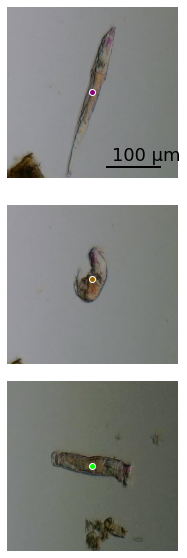

In [128]:
tmp = df["paths"].iloc[:].tolist()[::every_nth_frame]
ints = [int(n.split("/")[-1].split(".png")[0]) for n in tmp]


highlight_frames = [84, 216, 312]
#plt.figure(figsize=(6,6))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
longest = 800 # 800 pixels is longest extension

for nth, cframe in enumerate(highlight_frames):
    # image stuff
    cimg = cv2.imread(f"{frames_filepath}/frame_{str(cframe).zfill(zfill_)}.jpg", 1)  
    cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)

    # centroid stuff
    x, y = df_.loc[cframe, "centroid_x"], df_.loc[cframe, "centroid_y"]
    xlow, xhigh = x - (longest / 2), x + (longest / 2)
    ylow, yhigh = y - (longest / 2), y + (longest / 2)
    
    # Plotting stuff
    color_idx = np.where([i == cframe for i in ints])[0][0]
    ccolors = colors[color_idx]
        
    ax[nth].imshow(cimg)
    ax[nth].plot(x, y, "o", ms=6, mfc=ccolors, mec="w")
    # but mask might be better?

    # Axis stuff
    ax[nth].invert_yaxis()
    ax[nth].set_ylim([ylow, yhigh]); ax[nth].set_xlim([xlow, xhigh])
    ax[nth].set_axis_off()

scalebar_posx = 550
scalebar_posy = 300
ax[0].plot([scalebar_posx, scalebar_posx + scaled_width], [scalebar_posy, scalebar_posy], "-k", lw=2)
ax[0].text(scalebar_posx + (scaled_width/10), scalebar_posy + 25, f"{desired_scale_width} µm", size="large")

plt.tight_layout()
plt.savefig(f"{save_figure_path}-Individual-frames-highlighted.jpg", dpi=300)


In [105]:
desired_scale_width = 100  # in mu
scaled_width = desired_scale_width / (pixel_per_real_width)
print(scaled_width)

scalebar_posx = 800
scalebar_posy = 100

250.0


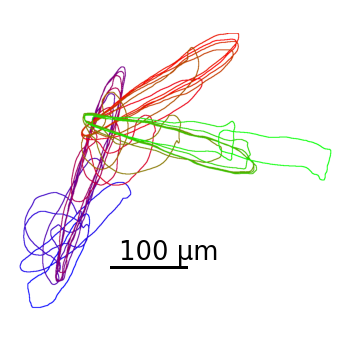

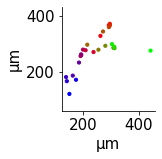

In [179]:
every_nth_frame = 12 # subsampling of frames to illustrate

df["frame_shown"] = 0
frame_idx = np.arange(0, num_frames, every_nth_frame)
df.loc[frame_idx, "frame_shown"] = 1

#highlight_frames = []
contour_lw = 2  # contor line width
sub_move = {1 : range(124),
            2 : range(125, num_frames)}

sub_move = {1 : range(num_frames)}

for k, v in sub_move.items():
    # devide into movement sequenes if necessary
    move = df["paths"].iloc[v].tolist()[::every_nth_frame]

    contours_ = list()
    for nth in range(len(move)):
        m = move[nth]
        im = cv2.imread(m)
        imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)
        contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_.append(contours)

    # Visualization
    desired_cmap = "brg" # "magma" #"turbo" # "twilight"  # nipy_spectral" # "bwr"  # "nipy_spectral" # "jet", "bwr"
    cmap = plt.get_cmap(desired_cmap)
    colors = [cmap(i)[:3] for i in np.linspace(0, 1, len(move))]

    if background_color == "w":
        background = np.ones_like(im) * 255
    else:
        background = np.zeros_like(im)
    
    # Draw contours
    for nth in range(len(move)):
        ccolors = colors[nth]
        ccolors = [ccolors[0] * 255, ccolors[1] * 255, ccolors[2] * 255]
        cnt = contours_[nth]
        cv2.drawContours(background, cnt, 0, (ccolors[0], ccolors[1], ccolors[2]), contour_lw)

    # Plot
    plt.figure(figsize=(5,5))
    plt.imshow(background)
    plt.axis("equal");
    plt.ylim([100, 1150]); plt.xlim([200, 1300])
    plt.xlabel("pixels"); plt.ylabel("pixels")

    # Scalebar
    plt.plot([scalebar_posx, scalebar_posx + scaled_width], [scalebar_posy, scalebar_posy], "-k", lw=3)  # 2
    plt.text(scalebar_posx + (scaled_width/10), scalebar_posy + 25, f"{desired_scale_width} µm", size="xx-large") # x-large
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{save_figure_path}-submovement_{k}-fps_{fps}-subsampled_{every_nth_frame}-background_{background_color}.jpg", dpi=300)

    # Centroids
    centroids_x, centroids_y = [], []
    for cnt in contours_:
        M = cv2.moments(cnt[0])
        centroids_x.append(int(M['m10']/M['m00']))
        centroids_y.append(int(M['m01']/M['m00']))

    plt.figure(figsize=(2.5,2.5))
    plt.scatter(np.array(centroids_x) * pixel_per_real_width, np.array(centroids_y) * pixel_per_real_width, c=colors, s=10)
    plt.ylim([200*pixel_per_real_width, 950*pixel_per_real_width]); plt.xlim([200*pixel_per_real_width, 1300*pixel_per_real_width])
    plt.axis("equal"); #plt.axis("off")
    plt.xlabel("µm"); plt.ylabel("µm")
    plt.tight_layout()
    plt.savefig(f"{save_figure_path}-submovement_{k}-fps_{fps}-subsampled_{every_nth_frame}-background_{background_color}-centroids.jpg", dpi=300)


In [198]:
move = df["paths"].iloc[:].tolist()#[::every_nth_frame]

aspect_ratios = []
orients = []
min_rect_area = []
extents = list()
areas = list()
perimeters = list()
centroids_x, centroids_y = [], []
diff_centroids = []
for nth in range(len(move)):
    m = move[nth]
    im = cv2.imread(m)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cnt = contours[-1]
    M = cv2.moments(cnt)

    # Centroids
    centroids_x.append(int(M['m10']/M['m00']))
    centroids_y.append(int(M['m01']/M['m00']))
    
    # Area
    area = cv2.contourArea(cnt)
    areas.append(area)

    # perimeter
    perimeters.append(cv2.arcLength(cnt, True))

    # extent
    x,y,w,h = cv2.boundingRect(cnt)
    rect_area = w * h
    #extent = float(area) / rect_area
    #extents.append(extent)

    # aspect ratio
    #aspect_ratios.append(float(w)/h)
    
    # Orients
    (x,y), (MA,ma), angle = cv2.fitEllipse(cnt)
    orients.append(angle)

    # rotated bounding box
    (x,y), (MA,ma), angle = cv2.minAreaRect(cnt)
    min_rect_area.append(w * h)

    # extent modified
    extents.append(float(area) / (w * h))
    
    aspect_ratios.append(float(w)/h)


In [199]:
x_frames = np.linspace(0, len(move), len(move)).astype("int")
x_time = np.linspace(0, len(move) / fps, len(move))

df_ = pd.DataFrame(x_frames, columns=["frame"])
df_["time"] = x_time

df_["centroid_x"] = centroids_x
df_["centroid_y"] = centroids_y
df_["area"] = areas
df_["min_area"] = min_rect_area

# CLEAN AREA
remove_idx = df_[df_["area"] < 5].index.values[0]
df_["extent"] = extents
df_["perimeter"] = perimeters
df_["aspect_ratio"] = aspect_ratios
df_["orientation"] = orients

# Replace with NaNs for all measures and time
df_.iloc[remove_idx, :] = np.nan
df_["centroid_dist"] = np.sqrt((df_["centroid_x"].diff() ** 2) + (df_["centroid_y"].diff() ** 2))


In [200]:
bidx = (df_["time"] > 2.75) & (df_["time"] < 5)
df_[bidx]  # 91 > take frame 84

bidx = (df_["time"] > 9) & (df_["time"] < 10)
df_[bidx] # 217 > take 216

bidx = (df_["time"] > 12.7)
df_[bidx] # 308 > take 312 

# check wheter the frames illustrated are met
# read in frame and transfer to RGB
# limit axis

,frame,time,centroid_x,centroid_y,area,min_area,extent,perimeter,aspect_ratio,orientation,centroid_dist
304,304.0,12.707006,774.0,739.0,35178.0,69135.0,0.508831,1061.955405,2.539394,79.126366,2.828427
305,305.0,12.748806,776.0,739.0,34789.5,67156.0,0.518040,1049.369619,2.527607,79.601791,2.000000
306,306.0,12.790605,797.0,735.0,34247.0,64236.0,0.533143,1018.156417,2.540881,79.708015,21.377558
307,307.0,12.832404,837.0,730.0,33606.0,62884.0,0.534413,1002.014282,2.518987,79.900223,40.311289
308,308.0,12.874204,881.0,723.0,33592.5,62329.0,0.538955,1003.428494,2.528662,80.912109,44.553339
309,309.0,12.916003,932.0,716.0,33193.5,62146.0,0.534121,994.114785,2.397516,79.374504,51.478151
310,310.0,12.957803,985.0,708.0,32643.0,61884.0,0.527487,977.327989,2.358025,78.798332,53.600373
311,311.0,12.999602,1041.0,699.0,32262.5,61560.0,0.524082,965.227483,2.345679,78.405426,56.718604
312,312.0,13.041401,1104.0,688.0,32855.0,63336.0,0.518741,967.327988,2.244048,77.543053,63.953108
313,313.0,13.083201,1169.0,677.0,33002.0,63126.0,0.522796,967.813270,2.263473,77.958374,65.924199


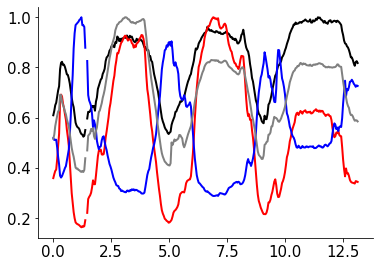

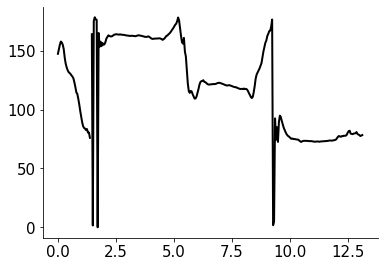

In [201]:

# CLEAN THIS UP
plt.figure(figsize=(6,4.25))
plt.plot(df_["time"], df_["area"] / df_["area"].max(), "-k", lw=2, label="area") 
plt.plot(df_["time"], df_["min_area"] / df_["min_area"].max(), "-r", lw=2, label="marea") 
plt.plot(df_["time"], df_["extent"] / df_["extent"].max(), "-b", lw=2, label="")  # 
plt.plot(df_["time"], df_["perimeter"] / df_["perimeter"].max(), "-", color="gray", lw=2, label="perimeter")
plt.figure(figsize=(6,4.25))
plt.plot(df_["time"], df_["orientation"] , "-k", lw=2, label="")

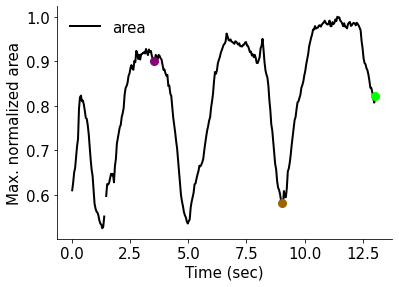

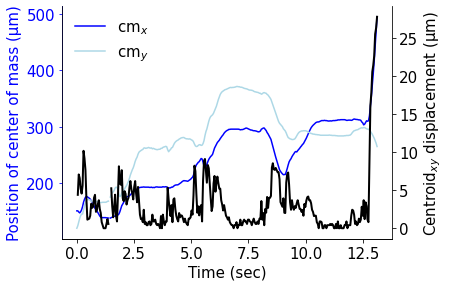

In [207]:
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 15


# CLEAN THIS UP
plt.figure(figsize=(5.8,4.25))
plt.plot(df_["time"], df_["area"] / df_["area"].max(), "-k", lw=2, label="area")
#plt.plot(df_["time"], df_["extent"] / df_["extent"].max(), "-k", lw=2, label="extent")
#plt.plot(df_["time"], df_["perimeter"] / df_["perimeter"].max(), "-", color="gray", lw=2, label="perimeter")

for cframe in highlight_frames:
    color_idx = np.where([i == cframe for i in ints])[0][0]
    plt.plot(df_.loc[cframe, "time"], df_.loc[cframe, "area"] / df_["area"].max(), "o", color=colors[color_idx], ms=8)
    #plt.plot(df_.loc[cframe, "time"], df_.loc[cframe, "extent"] / df_["extent"].max(), "o", color=colors[color_idx], ms=8)
    #plt.plot(df_.loc[cframe, "time"], df_.loc[cframe, "perimeter"] / df_["perimeter"].max(), "o", color=colors[color_idx], ms=8)

plt.xlabel("Time (sec)"); plt.ylabel("Max. normalized area");
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-area.jpg", dpi=300)


plt.figure(figsize=(6.5,4.25))
ax1 = plt.gca()
ax1.plot(df_["time"], df_["centroid_x"] * pixel_per_real_width, "-", color="blue", lw=1.5, label="cm$_x$")
ax1.plot(df_["time"], df_["centroid_y"] * pixel_per_real_width, "-", color="lightblue", lw=1.5, label="cm$_y$")
ax1.set_ylabel("Position of center of mass (µm)"); ax1.set_xlabel("Time (sec)"); 
ax1.spines["left"].set_color("blue")
ax1.yaxis.label.set_color("blue")
ax1.tick_params(axis="y", color="blue")
ax1.set_yticklabels(labels=[int(x) for x in ax1.get_yticks()], color="blue")

ax2 = plt.twinx()
ax2.plot(df_["time"], df_["centroid_dist"] * pixel_per_real_width, "-k", lw=2)
ax2.spines["right"].set_visible(True)
ax2.spines["right"].set_color("black")

ax2.set_xlabel("Time (sec)"); ax2.set_ylabel("Centroid$_x$$_y$ displacement (µm)");
ax1.legend(frameon=False)
plt.tight_layout()
plt.savefig(f"{save_figure_path}-timedependent-fps_{fps}-centroids.jpg", dpi=300)


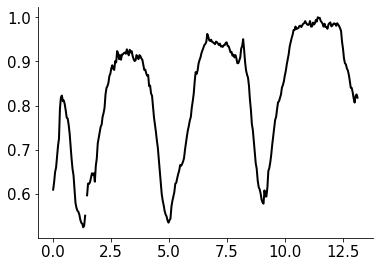

In [180]:
plt.figure(figsize=(6,4.25))
plt.plot(df_["time"], df_["area"] / df_["area"].max(), "-k", lw=2, label="area")


TO DO
- image cutout of highlighted frames
- select frames to highlight
- occupancy map?

In [ ]:
#seg_mask_path = "./data/results/2024_0205_101231_022_7sec_masks"  #


In [ ]:
# extract the contours only from segmentation masks, get outline